# Lab 1: Independent Component Analysis

### Machine Learning 2 (2019)

* The lab exercises can be done in groups of two people, or individually.
* The deadline is Tuesday September 17th, 16:59.
* Assignment should be submitted through Canvas! Make sure to include your and your teammates' names with the submission.
* Attach the .IPYNB (IPython Notebook) file containing your code and answers. Naming of the file should be "studentid1\_studentid2\_lab#", for example, the attached file should be "12345\_12346\_lab1.ipynb". Only use underscores ("\_") to connect ids, otherwise the files cannot be parsed.

Notes on implementation:

* You should write your code and answers in an IPython Notebook: http://ipython.org/notebook.html. If you have problems, please ask.
* Use __one cell__ for code and markdown answers only!
    * Put all code in the cell with the ```# YOUR CODE HERE``` comment and overwrite the ```raise NotImplementedError()``` line.
    * For theoretical questions, put your solution using LaTeX style formatting in the YOUR ANSWER HERE cell.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* Large parts of you notebook will be graded automatically. Therefore it is important that your notebook can be run completely without errors and within a reasonable time limit. To test your notebook before submission, select Kernel -> Restart \& Run All.

### Literature
In this assignment, we will implement the Independent Component Analysis algorithm as described in chapter 34 of David MacKay's book "Information Theory, Inference, and Learning Algorithms", which is freely available here:
http://www.inference.phy.cam.ac.uk/mackay/itila/book.html

Read the ICA chapter carefuly before you continue!

### Notation

$\mathbf{X}$ is the $M \times T$ data matrix, containing $M$ measurements at $T$ time steps.

$\mathbf{S}$ is the $S \times T$ source matrix, containing $S$ source signal values at $T$ time steps. We will assume $S = M$.

$\mathbf{A}$ is the mixing matrix. We have $\mathbf{X} = \mathbf{A S}$.

$\mathbf{W}$ is the matrix we aim to learn. It is the inverse of $\mathbf{A}$, up to indeterminacies (scaling and permutation of sources).

$\phi$ is an elementwise non-linearity or activation function, typically applied to elements of $\mathbf{W X}$.

### Code
In the following assignments, you can make use of the signal generators listed below.



In [1]:
%pylab inline
import sys
assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed"

# Signal generators
def sawtooth(x, period=0.2, amp=1.0, phase=0.):
    return (((x / period - phase - 0.5) % 1) - 0.5) * 2 * amp

def sine_wave(x, period=0.2, amp=1.0, phase=0.):
    return np.sin((x / period - phase) * 2 * np.pi) * amp

def square_wave(x, period=0.2, amp=1.0, phase=0.):
    return ((np.floor(2 * x / period - 2 * phase - 1) % 2 == 0).astype(float) - 0.5) * 2 * amp

def triangle_wave(x, period=0.2, amp=1.0, phase=0.):
    return (sawtooth(x, period, 1., phase) * square_wave(x, period, 1., phase) + 0.5) * 2 * amp

def random_nonsingular_matrix(d=2):
    """
    Generates a random nonsingular (invertible) matrix of shape d*d
    """
    epsilon = 0.1
    A = np.random.rand(d, d)
    while abs(np.linalg.det(A)) < epsilon:
        A = np.random.rand(d, d)
    return A

def plot_signals(X, title="Signals"):
    """
    Plot the signals contained in the rows of X.
    """
    figure()
    
    for i in range(X.shape[0]):
        ax = plt.subplot(X.shape[0], 1, i + 1)
        plot(X[i, :])
        ax.set_xticks([])
        ax.set_yticks([])
    plt.suptitle(title)

Populating the interactive namespace from numpy and matplotlib


The following code generates some toy data to work with.

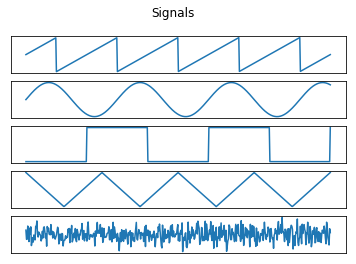

In [2]:
# Generate data
num_sources = 5
signal_length = 500
t = linspace(0, 1, signal_length)
S = np.c_[sawtooth(t), sine_wave(t, 0.3), square_wave(t, 0.4), triangle_wave(t, 0.25), np.random.randn(t.size)].T
plot_signals(S)

### 1.1 Make mixtures (5 points)
Write a function `make_mixtures(S, A)' that takes a matrix of source signals $\mathbf{S}$ and a mixing matrix $\mathbf{A}$, and generates mixed signals $\mathbf{X}$.

In [3]:
### 1.1 Make mixtures
def make_mixtures(S, A):
    X = np.matmul(A,S)
    
    return X

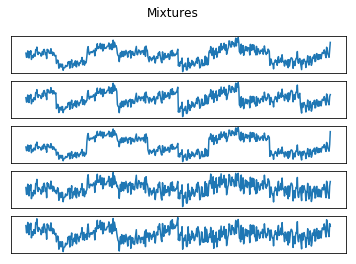

In [4]:
### Test your function
np.random.seed(42)
A = random_nonsingular_matrix(d=S.shape[0])
X = make_mixtures(S, A)
plot_signals(X, "Mixtures")

assert X.shape == (num_sources, signal_length), "The shape of your mixed signals is incorrect"


### 1.2 Histogram (5 points)
Write a function `plot_histograms(X)` that takes a data-matrix $\mathbf{X}$ and plots one histogram for each signal (row) in $\mathbf{X}$. You can use the `np.histogram()` (followed by `plot`) or `plt.hist()` function. 

Plot histograms of the sources and the measurements.

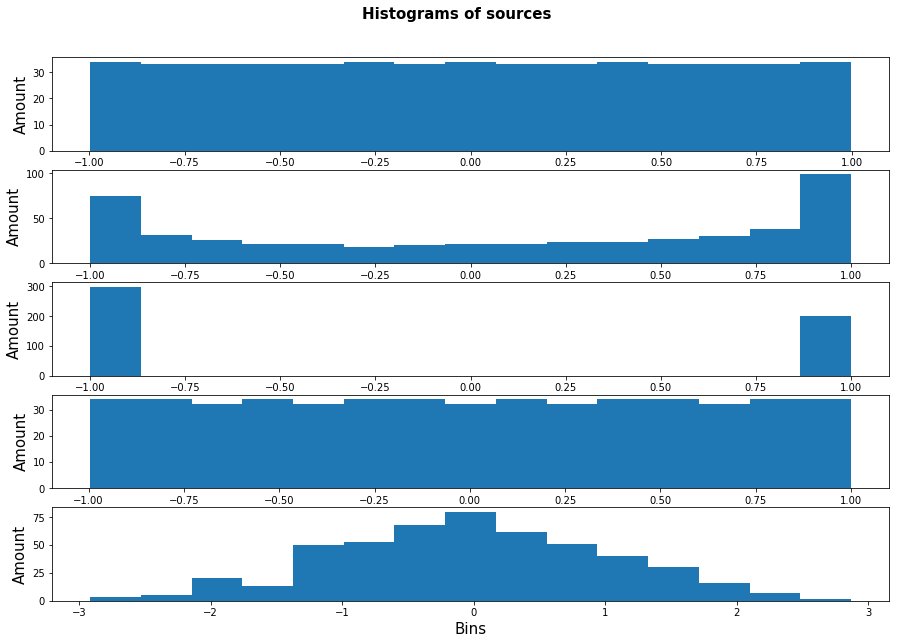

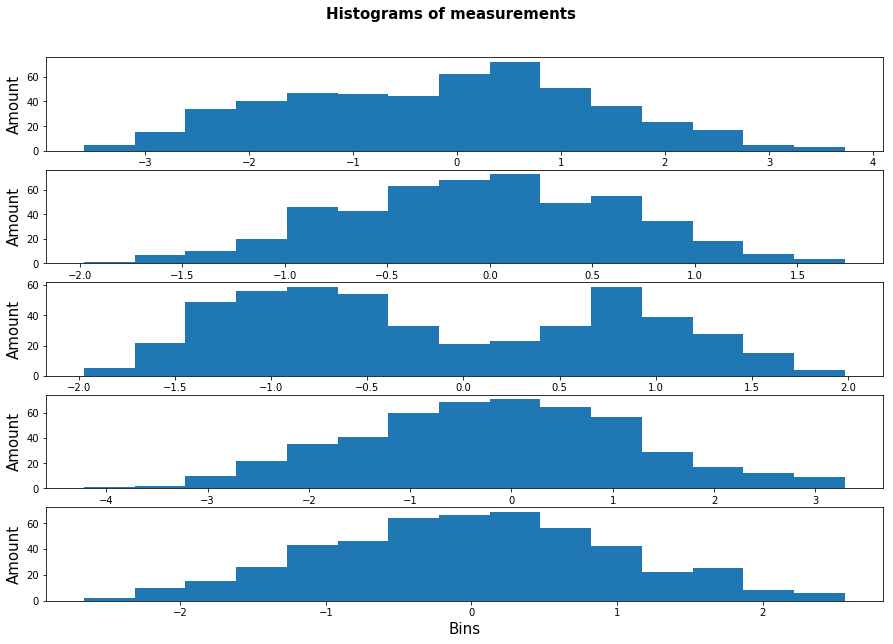

In [5]:
### 1.2 Histogram

def plot_histograms(X,title="Histograms"):
    
    rows = X.shape[0]
    fig = plt.figure(figsize=(15, 10))
    fig.suptitle(title, fontweight="bold",fontsize=15,y=0.95)
    
    for i,row in enumerate(X):
        ax = plt.subplot(rows,1,i+1)
        plt.hist(row,bins=15)
        plt.ylabel('Amount',fontsize=15)
        plt.xlabel('Bins',fontsize=15)
    
    plt.show()

    
plot_histograms(S,"Histograms of sources")    
plot_histograms(X,"Histograms of measurements")

Which of these distributions (sources or measurements) tend to look more like Gaussians? Can you think of an explanation for this phenomenon? Why is this important for ICA?

The measurements look more like Gaussians like a (skewed) Bell shape, while the sources has some uniform shapes in some of them. Especially the last one of the measurement, which was a random source. It is important for the sources to be Non-Gaussian in ICA, otherwise there might be ambiguity. $X = AS$, if assuming s is Gaussian, $x$ will also be Gaussian. But a multivariate standard normal distribution has the property that it is rotationally symmetric. Due to this, one cannot distinguish between different mixing matrices that resulted in $x$ leading to unable to learn a proper $W$, which is the inverse of the mixing matrix, to recover the original sources. This is why one of the assumption in ICA is that the sources are non-Gaussian and given enough data, it is possible to recover the original n sources. 

### 1.3 Implicit priors (20 points)
As explained in MacKay's book, an activation function $\phi$ used in the ICA learning algorithm corresponds to a prior distribution over sources. Specifically, $\phi(a) = \frac{d}{da} \ln p(a)$. For each of the following activation functions, *derive* the source distribution they correspond to.
$$\phi_0(a) = -\tanh(a)$$
$$\phi_1(a) = -a + \tanh(a)$$
$$\phi_2(a) = -a^3$$
$$\phi_3(a) = -\frac{6a}{a^2 + 5}$$

Give your answer without the normalizing constant, so an answer of the form $p(a) \propto \verb+[answer]+$ is ok.

### General
For the general form, $\phi(a) = \frac{d}{da} \ln p(a)$, we want to isolate the p(a), thus first use the rule below as antiderivative: 

$$ \int \phi(a) da = \ln p(a) $$

Then some known integration rules and properties are used such as the Sum, Power and Variable rules and a rule to work out the tanh function :

$$ \int tanh(ax) dx = a^{-1} \ln(cosh(ax)) + C $$

Lastly, trying to get everyting inside a logarithm to divide by the logarithm cancel both sides out.

### 1.   $\phi_0(a) = -\tanh(a)$
    
$$\ln p_0(a) = \int -\tanh(a) \text{ da}$$
$$ \ln p_0(a) \propto - \ln(cosh(a)) + C       $$
$$ \ln p_0(a) \propto \ln(cosh(a)^{-1})         $$
$$ p_0(a) \propto  cosh(a)^{-1}         $$
$$ p_0(a) \propto  \frac{1}{cosh(a)}  \propto  \frac{1}{\frac{e^a + e^{-a}} {2}} \propto  \frac{2}{e^a + e^{-a}}       $$

### 2. $\phi_1(a) = -a + \tanh(a)$

$$\ln p_1(a) = \int -a + \tanh(a) \text{ da}$$
$$\ln p_1(a) = - \int a \text{ da} + \int \tanh(a) \text{ da}$$
$$ \ln p_1(a) \propto -\frac{a^2}{2} +  \ln(cosh(a)) + C       $$
$$ \ln p_1(a) \propto \ln exp(\frac{-a^2}{2}) +  \ln(cosh(a))       $$
$$ \ln p_1(a) \propto \ln ( exp(\frac{-a^2}{2}) cosh(a))      $$
$$ p_1(a) \propto e^{\frac{-a^2}{2}} * cosh(a)      $$

### 3. $\phi_2(a) = -a^3$

$$\ln p_2(a) = \int -a^3\text{ da}$$
$$ \ln p_2(a) \propto -\frac{a^4}{4} +  C       $$
$$ \ln p_2(a) \propto \ln( exp(-\frac{a^4}{4}))        $$
$$ p_2(a) \propto e^{-\frac{a^4}{4}}        $$

### 4. $\phi_3(a) = -\frac{6a}{a^2 + 5}$

$$\ln p_3(a) = \int -\frac{6a}{a^2 + 5} \text{ da}$$

Here will use the following rule:

$$ \int \frac{f'(a)}{f(a)} \text{ da} = \ln |f(a)| + C $$

To continue:
$$\ln p_3(a) = -3 \int \frac{2a}{a^2 + 5} \text{ da}$$
$$\ln p_3(a) \propto -3 \ln|{a^2 + 5}| + C$$
$$\ln p_3(a) \propto  \ln|({a^2 + 5})^{-3}| $$
$$p_3(a) \propto  ({a^2 + 5})^{-3} \propto \frac{1}{{(a^2 + 5})^{3}} $$


In [6]:
def phi_0(a):
    return -np.tanh(a)

def p_0(a):
    p_0 = 1 / np.cosh(a)
    
    return p_0

In [7]:
def phi_1(a):
    return -a + np.tanh(a)

def p_1(a):
    p_1 = np.exp((-a**2)/2) * np.cosh(a)
    
    return p_1

In [8]:
def phi_2(a):
    return -a**3

def p_2(a):
    p_2 = np.exp((-a**4)/4)
    
    return p_2

In [9]:
def phi_3(a):
    return -6*a / (a**2 + 5)

def p_3(a):
    p_3 = 1 / (a**2 + 5)**3
    
    return p_3

In [10]:
activation_functions = [phi_0, phi_1, phi_2, phi_3]
priors = [p_0, p_1, p_2, p_3]

a = np.linspace(-5, 5, 1000)
for prior in priors:
    assert prior(a).shape == (1000, ), "Wrong output shape"


Plot the activation functions and the corresponding prior distributions, from $a = -5$ to $5$ (hint: use the lists defined in the cell above). Compare the shape of the priors to the histogram you plotted in the last question.

'\nThe priors take on the form of a bell-shaped curve, where p0 and p3 look the most as a standard normal,\nwhile the other two have a little flat surface. \nThis is similar to the histograms from before, where we saw that the measurements had these kind of forms, \nespecially the random one.\n'

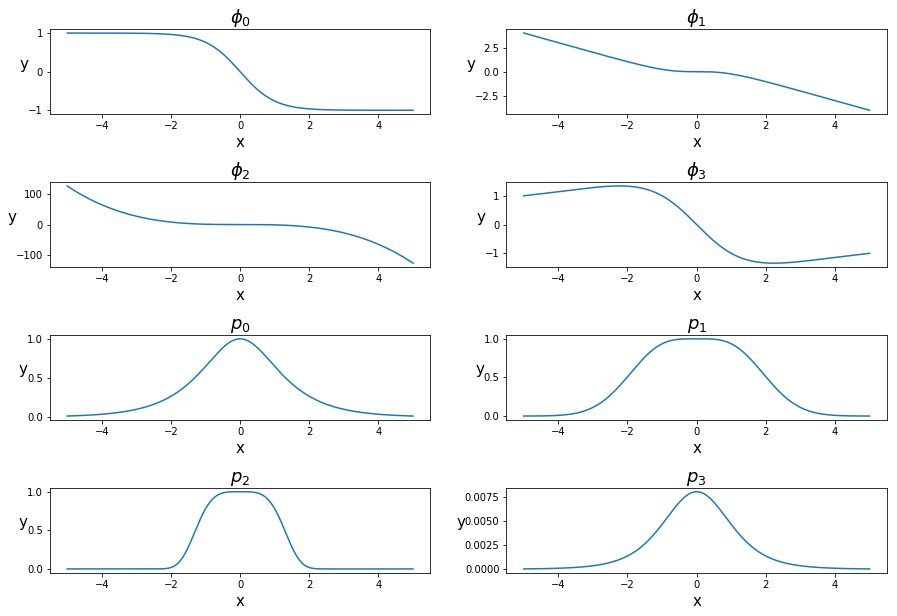

In [11]:
### 1.3 Implicit priors (continued)
a = np.linspace(-5, 5, 1000)

labels = ['$\phi_0$','$\phi_1$','$\phi_2$','$\phi_3$','$p_0$','$p_1$','$p_2$','$p_3$']
fig = plt.figure(figsize=(15, 10))

for i,distr in enumerate(activation_functions+priors):
    ax = plt.subplot(4,2,i+1)
    line = distr(a)
    plt.plot(a,line);
    plt.ylabel('y',fontsize=15).set_rotation(0)
    plt.xlabel('x',fontsize=15)
    ax.set_title(labels[i],fontsize=18,fontweight="bold")
    
plt.subplots_adjust(wspace = 0.2,hspace = 0.8)

'''
The priors take on the form of a bell-shaped curve, where p0 and p3 look the most as a standard normal,
while the other two have a little flat surface. 
This is similar to the histograms from before, where we saw that the measurements had these kind of forms, 
especially the random one.
'''

### 1.4 Whitening (15 points)
Some ICA algorithms can only learn from whitened data. Write a method `whiten(X)` that takes a $M \times T$ data matrix $\mathbf{X}$ (where $M$ is the dimensionality and $T$ the number of examples) and returns a whitened matrix. If you forgot what whitening is or how to compute it, various good sources are available online, such as http://courses.media.mit.edu/2010fall/mas622j/whiten.pdf. Your function should also center the data before whitening.

In [12]:
### 1.4 Whitening
def whiten(X):

    centered_X = X - np.mean(X, axis=1).reshape((X.shape[0],-1))
    cov_X = np.cov(centered_X)
    eigen_values,eigen_vectors = np.linalg.eig(cov_X)
    
    A_w = np.matmul( eigen_vectors,np.diag(eigen_values**(-0.5)))
    whitened_X = np.matmul(A_w.T , centered_X)
    
    return whitened_X

In [13]:
### Test your function
Xw = whiten(X)
assert Xw.shape == (num_sources, signal_length), "The shape of your mixed signals is incorrect"


### 1.5 Interpret results of whitening (10 points)
Make 3 figures, one for the sources, one for measurements and one for the whitened measurements. In each figure, make $5 \times 5$ subplots with scatter plots for each pair of signals. Each axis represents a signal and each time-instance is plotted as a dot in this space. You can use the `plt.scatter()` function. Describe what you see.

Now compute and visualize the covariance matrix of the sources, the measurements and the whitened measurements. You can visualize each covariance matrix using this code:
```python
# Dummy covariance matrix C;
C = np.eye(5)  
ax = imshow(C, cmap='gray', interpolation='nearest')
```

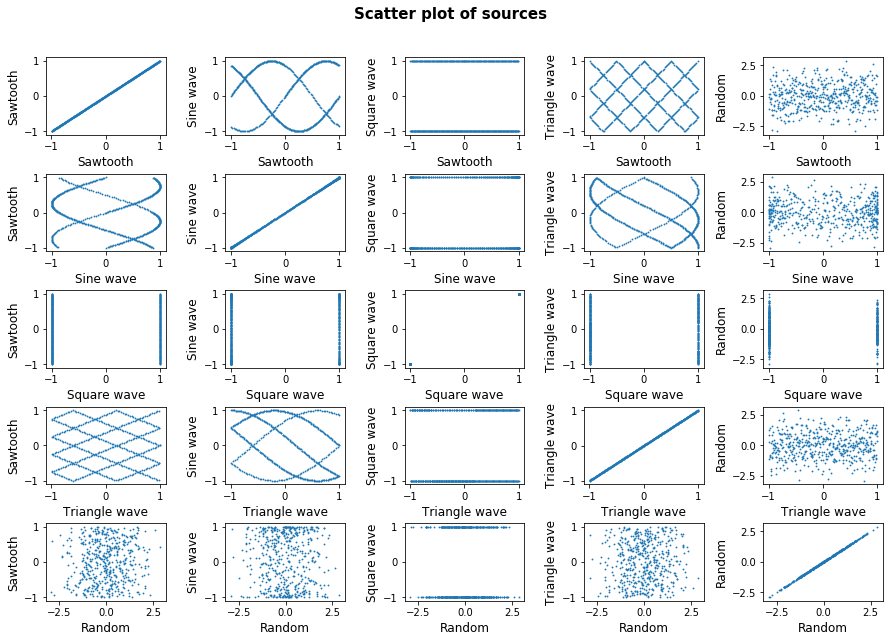

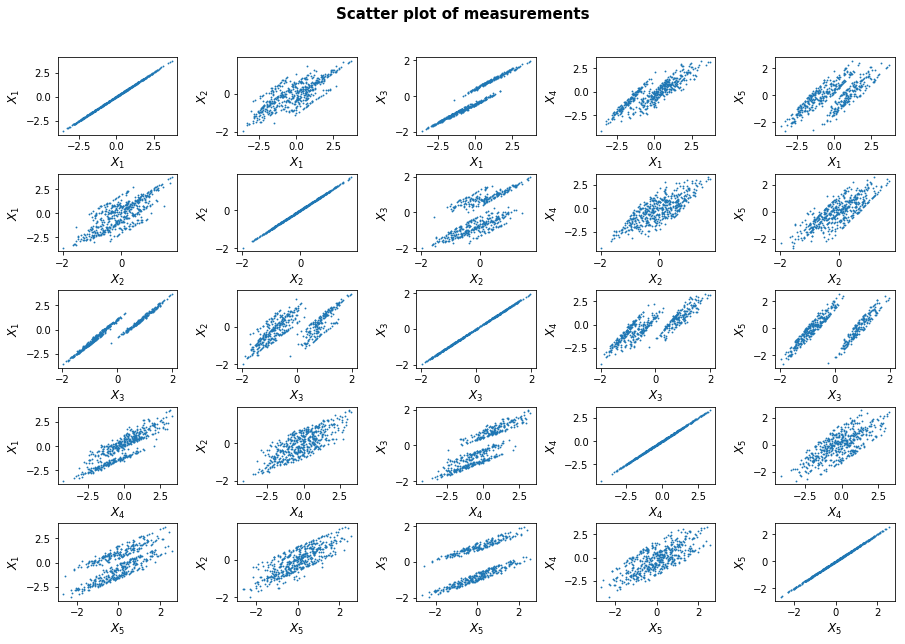

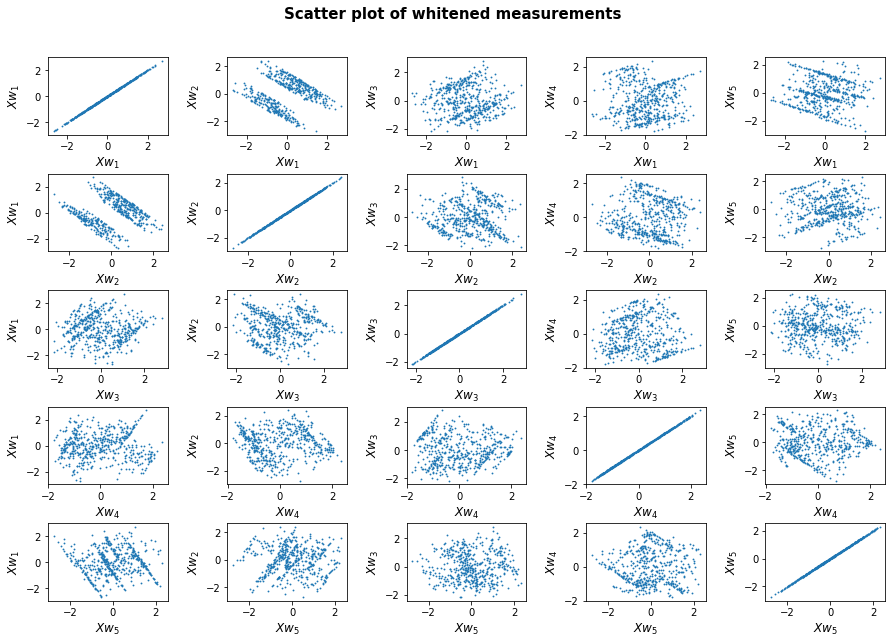

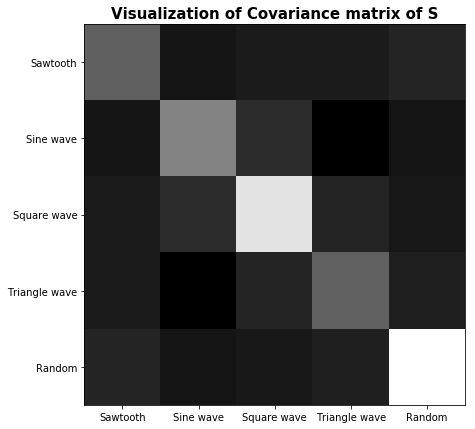

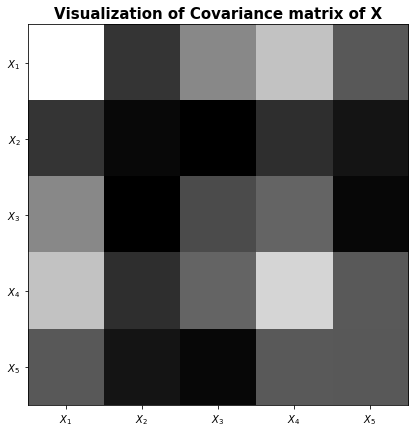

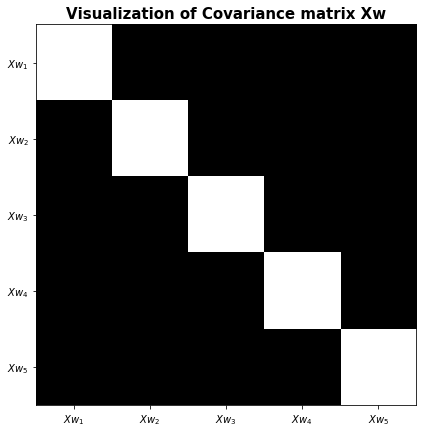

In [14]:
### 1.5 Interpret results of whitening
# YOUR CODE HERE

def plot_scatter(data,labels,title="Scatter plot"):
    
    fig = plt.figure(figsize=(15, 10))
    size = data.shape[0]
    plot_number = 1
    
    fig.suptitle(title, fontweight="bold",fontsize=15,y=0.95)
    
    for i,x in enumerate(data):
        for j,y in enumerate(data):
            ax = plt.subplot(size,size,plot_number)
            plt.scatter(x,y,s=0.7)
            plt.ylabel(labels[j],fontsize=12)
            plt.xlabel(labels[i],fontsize=12)
            plot_number += 1
            
    plt.subplots_adjust(wspace = 0.5,hspace = 0.5)  
    plt.show()

def visualize_cov(data,labels,title="Visualization of Covariance matrix"):
    
    fig = plt.figure(figsize=(7, 7))
    
    cov = np.cov(data)
    ax = imshow(cov, cmap='gray', interpolation='nearest')   
    plt.yticks(np.arange(5),labels)
    plt.xticks(np.arange(5),labels)
    plt.title(title,fontsize=15,fontweight="bold")
    plt.show()
    
labels_sources = ["Sawtooth","Sine wave", "Square wave", "Triangle wave","Random"]
labels_measurements = ["$X_1$","$X_2$","$X_3$","$X_4$","$X_5$"]
labels_measurements_w = ["$Xw_1$","$Xw_2$","$Xw_3$","$Xw_4$","$Xw_5$"]

plot_scatter(S,labels_sources,"Scatter plot of sources")
plot_scatter(X,labels_measurements,"Scatter plot of measurements")
plot_scatter(Xw,labels_measurements_w,"Scatter plot of whitened measurements")

visualize_cov(S,labels_sources,"Visualization of Covariance matrix of S")
visualize_cov(X,labels_measurements,"Visualization of Covariance matrix of X")
visualize_cov(Xw,labels_measurements_w, "Visualization of Covariance matrix Xw")

##### Describe what you see:
In the scatter plots, the correlation between each pair of signal can be observed. Signals plotted with itself ofcourse have a correlation of 1 and thus a straightline. Some sources have a little bit of correlation with others, but Random does not have any correlation with any other source, which is logical. Furthermore, measurements have a bit more correlation with lines or ellipses occuring more, this also makes sense as sources have mixed together now. 
Lastly, whitened measurements are decorrelated, which is why the scatter plots are all over the place except compared with itself ofcourse and some other cases have little stripes such as in Xw1 with Xw2 or Xw3. 

All of this is also supported in the visualization of the covariance matrices, having more white/lighter cells in the matrix means they are more correlated. Matrix of X has more white/grey than matrix of S for example, while the matrix of Xw is all black except for the white diagonal and confirms that it is an identity matrix with uniform diagonal variance.   

Are the signals independent after whitening?

After whitening, the signals are decorrelated and have an covariance matrix that is the identity matrix as visualized. However, having zero covariance does not always imply independence (but the converse is true). As mentioned before, some scatter plots in the whitened data have some stripes/lines such as the plots of pairs (Xw1,Xw2), (Xw1,Xw3),(Xw1,Xw5) and (Xw2,Xw5). Thus we cannot say be certain that they are indepedent of each other. Still since they are decorrelated, they can be used in ICA to find the sources. For time series data such as speech data, they are depedent on each other, even though ICA assumes that are indepdent, with sufficient data, the ICA can still have its desired performance.


### 1.6 Covariance (5 points)
Explain what a covariant algorithm is. 

#### From McKay: Maximum Likelihood and Covariant Algorithms for Independent Component Analysis, 1999

A covariant algorithm is an algorithm that is covariant that makes use of a curvature of the log likelihood to measure distances in the parameter space w, and is dimensionally consistent. The latter, meaning that the behaviour of the learning algorithm is covariant with respect to linear rescaling of the vector w in the update. And also such that the obtained matrix is positive definite to have a appropiate approximiation of the curvature of the log likelihood in the maximium likelihood case.

An example of a non-covariant algoirhtm is the steepest descent rule. Non-covariant algorithms maky take a long time to convergance, which is why in some cases people make use of a conjugate gradients, which adaptively figures out the curvature of the objective function to make it convergance faster. An example of covariant algorithm is the Newton algorihtm. 

### 1.7 Independent Component Analysis (25 points)
Implement the covariant ICA algorithm as described in MacKay. Write a function `ICA(X, activation_function, learning_rate)`, that returns the demixing matrix $\mathbf{W}$. The input `activation_function` should accept a function such as `lambda a: -tanh(a)`. Update the gradient in batch mode, averaging the gradients over the whole dataset for each update. Make it efficient, so use matrix operations instead of loops where possible (loops are slow in interpreted languages such as python and matlab, whereas matrix operations are internally computed using fast C code). Experiment with the learning rate and the initialization of $\mathbf{W}$. Your algorithm should be able to converge (i.e. `np.linalg.norm(grad) < 1e-5`) in within 10000 steps.

In [15]:
### 1.7 Independent Component Analysis
def ICA(X, activation_function, learning_rate=0.1,given_w=False,w_init=None,info=False,max_steps=10000):

    m,t = X.shape

    if given_w:
        w = w_init
    else:  
        w = np.random.normal(size=(m,m), scale=0.1)
    
    n_steps = 0
    condition_false = True
    
    #Decrease learning with a learning rate schedule based on the steps if learning rate 
    # is a little bit high, i.e. > 0.5, otherwise has problems to converge (or to NaN)
    if learning_rate > 0.5:
        do_lr_decay = True
        initial_lr = learning_rate
        decay = 0.001 
    else:
        do_lr_decay = False
    
    while condition_false:
        
            n_steps += 1
            
            a = np.matmul(w,X)
            z = activation_function(a)
            X_prime = np.matmul(w.T,a)

            gradient_w = w + (np.matmul(z,X_prime.T) / t)
            w = w + (learning_rate * gradient_w)
            
            grad_norm = np.linalg.norm(gradient_w) 
            
            if n_steps > 10000:
                print("ICA did not converge within ",max_steps)
                break
            elif np.isnan(grad_norm):
                print("Went to NaN")
                break
                
            condition_false = grad_norm > 1e-5 
            
            if do_lr_decay:
                learning_rate = (initial_lr / (1.0 + decay * n_steps))
    
    if not condition_false:
        print("ICA converged at step ",n_steps)
    
    if info:
        return w,n_steps,not condition_false
            
    return w

W_est = ICA(Xw, phi_3, learning_rate=0.5)  # Compare with ICA(X)

def test_different_settings():
    #Different learning rates and w initializations:
    for lr in [0.001,0.01,0.1,0.2,0.4,0.7,1]:
        for i, w_init in enumerate([ np.ones((Xw.shape[0],Xw.shape[0])),  #1
                        np.random.normal(size=(Xw.shape[0],Xw.shape[0]), scale=0.1),  #2
                        np.random.randn(Xw.shape[0],Xw.shape[0]), #3
                        random_nonsingular_matrix(d=Xw.shape[0]), #4
                        np.eye(Xw.shape[0]) ]): #5
            print("Lr ", lr, " W init number ", i+1)
            W_est = ICA(Xw, phi_3, lr,True,w_init)  
            print("-" * 50)
            
#test_different_settings()

ICA converged at step  829


In [16]:
# We will test your function so make sure it runs with only X and phi as input, and returns only W
# Also it should converge for all activation functions

W_estimates = [ICA(Xw, activation_function=phi, learning_rate=1.0) for phi in activation_functions]
assert all([W_est.shape == (num_sources, num_sources) for W_est in W_estimates])


ICA converged at step  405
ICA converged at step  604
ICA converged at step  1141
ICA converged at step  368


### 1.8 Experiments  (5 points)
Run ICA on the provided signals using each activation function $\phi_0, \ldots, \phi_3$ (or reuse `W_estimates`). Use the found demixing matrix $\mathbf{W}$ to reconstruct the signals and plot the retreived signals for each choice of activation function.

ICA converged at step  405
ICA converged at step  604
ICA converged at step  1141
ICA converged at step  334
ICA converged at step  433
ICA converged at step  641
ICA converged at step  1151
ICA converged at step  471


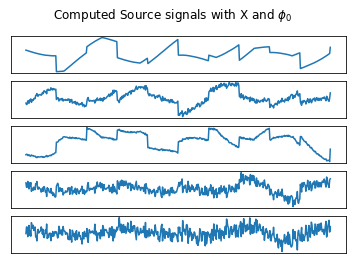

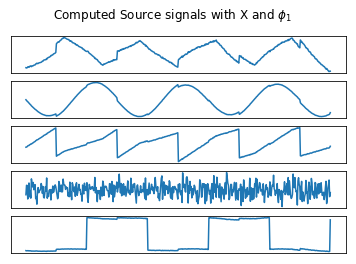

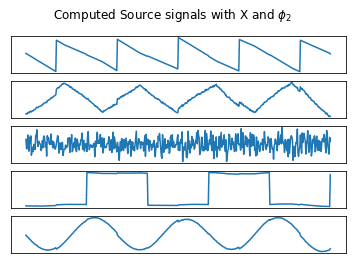

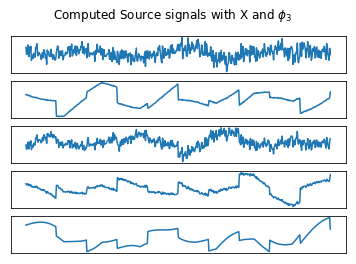

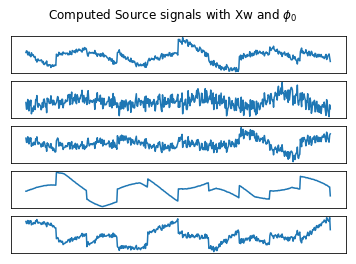

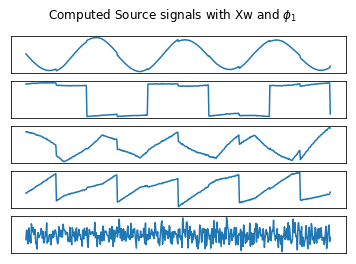

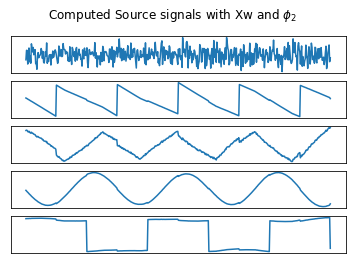

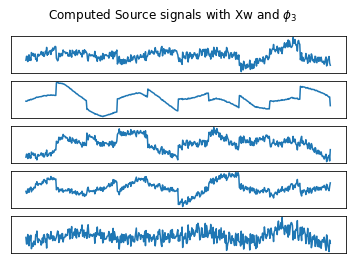

In [17]:
# 1.8 Experiments

labels = ['X and $\phi_0$','X and $\phi_1$','X and $\phi_2$','X and $\phi_3$']
labels_xw = ['Xw and $\phi_0$','Xw and $\phi_1$','Xw and $\phi_2$','Xw and $\phi_3$']

def plot_all_signals(data,W_estimates,labels):
    
    recon_signals = []
    
    for i,w in enumerate(W_estimates):
        s = np.matmul(w,data)
        plot_signals(s, "Computed Source signals with " + labels[i])
        recon_signals.append(s)
        
    return recon_signals

W_estimates = [ICA(Xw, activation_function=phi, learning_rate=1.0) for phi in activation_functions]
W_estimates_X = [ICA(X, activation_function=phi, learning_rate=1.0) for phi in activation_functions]
        
recon_X_s = plot_all_signals(X,W_estimates_X,labels)
recon_Xw_s = plot_all_signals(Xw,W_estimates,labels_xw)

In [18]:
import time

def does_whitening_make_a_difference():
    # Does it make a difference (in terms of speed of convergence) 
    # if you whiten your data before running ICA?
    
    # Return True or False
    # YOUR CODE HERE
    x_n_steps = []
    xw_n_steps = []
    
    #X
    start = time.time()
    
    for phi in activation_functions:
        w_x,n_steps_x,converged_x = ICA(X, activation_function=phi, learning_rate=1.0,info=True)

        if converged_x:
            x_n_steps.append(n_steps_x)

    end = time.time()
    x_time = end-start

        
    #Xw 
    start = time.time()
    
    for phi in activation_functions:
        w_xw,n_steps_xw,converged_xw = ICA(Xw, activation_function=phi, learning_rate=1.0,info=True)

        if converged_xw:
            xw_n_steps.append(n_steps_xw)
    
    end = time.time()
    xw_time = end-start
                    
    x_avg = np.mean(x_n_steps)
    xw_avg = np.mean(xw_n_steps)
    
    if  xw_time < x_time:
        does_make_diff = True
    else:
        does_make_diff = False
        
    #print("Mean steps for X ", x_avg)
    #print("Mean steps for whitened X ", xw_avg)
    #print("Time X ", x_time)
    #print("Time whitened X ", xw_time)
    
    return does_make_diff


diff = does_whitening_make_a_difference()
print(diff)

ICA converged at step  433
ICA converged at step  641
ICA converged at step  1151
ICA converged at step  444
ICA converged at step  405
ICA converged at step  604
ICA converged at step  1141
ICA converged at step  445
True


In [19]:
assert type(does_whitening_make_a_difference()) == bool

ICA converged at step  472
ICA converged at step  641
ICA converged at step  1151
ICA converged at step  495
ICA converged at step  405
ICA converged at step  604
ICA converged at step  1141
ICA converged at step  414


### 1.9 Audio demixing (10 points)
The 'cocktail party effect' refers to the ability humans have to attend to one speaker in a noisy room. We will now use ICA to solve a similar but somewhat idealized version of this problem. The code below loads 5 sound files and plots them.

Use a random non-singular mixing matrix to mix the 5 sound files. You can listen to the results in your browser using `play_signals`, or save them to disk if this does not work for you. Plot histograms of the mixed audio and use your ICA implementation to de-mix these and reproduce the original source signals. As in the previous exercise, try each of the activation functions.

Keep in mind that this problem is easier than the real cocktail party problem, because in real life there are often more sources than measurements (we have only two ears!), and the number of sources is unknown and variable. Also, mixing is not instantaneous in real life, because the sound from one source arrives at each ear at a different point in time. If you have time left, you can think of ways to deal with these issues.

In [20]:
import scipy.io.wavfile
from IPython.display import Audio, display, Markdown

# Save mixtures to disk, so you can listen to them in your audio player
def save_wav(data, out_file, rate):
    scaled = np.int16(data / np.max(np.abs(data)) * 32767)
    scipy.io.wavfile.write(out_file, rate, scaled)

# Or play them in your browser
def play_signals(S, sample_rate, title="Signals"):
    display(Markdown(title))
    for signal in S:
        display(Audio(signal, rate=sample_rate))

Signals

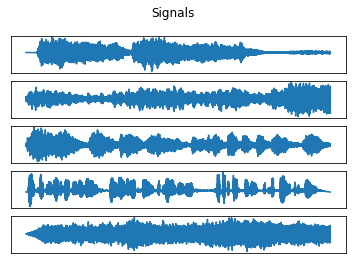

In [21]:
# Load audio sources
source_files = ['beet.wav', 'beet9.wav', 'beet92.wav', 'mike.wav', 'street.wav']
wav_data = []
sample_rate = None
for f in source_files:
    sr, data = scipy.io.wavfile.read(f, mmap=False)
    if sample_rate is None:
        sample_rate = sr
    else:
        assert(sample_rate == sr)
    wav_data.append(data[:190000])  # cut off the last part so that all signals have same length

# Create source and measurement data
S_audio = np.c_[wav_data]
plot_signals(S_audio)
play_signals(S_audio, sample_rate)

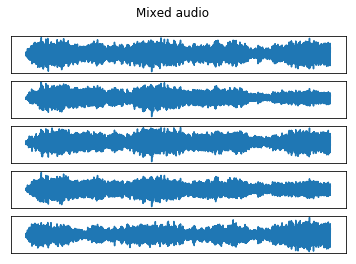

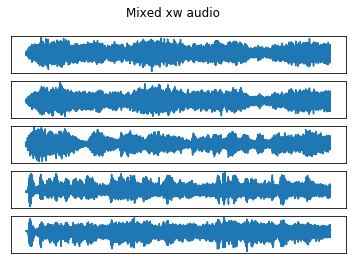

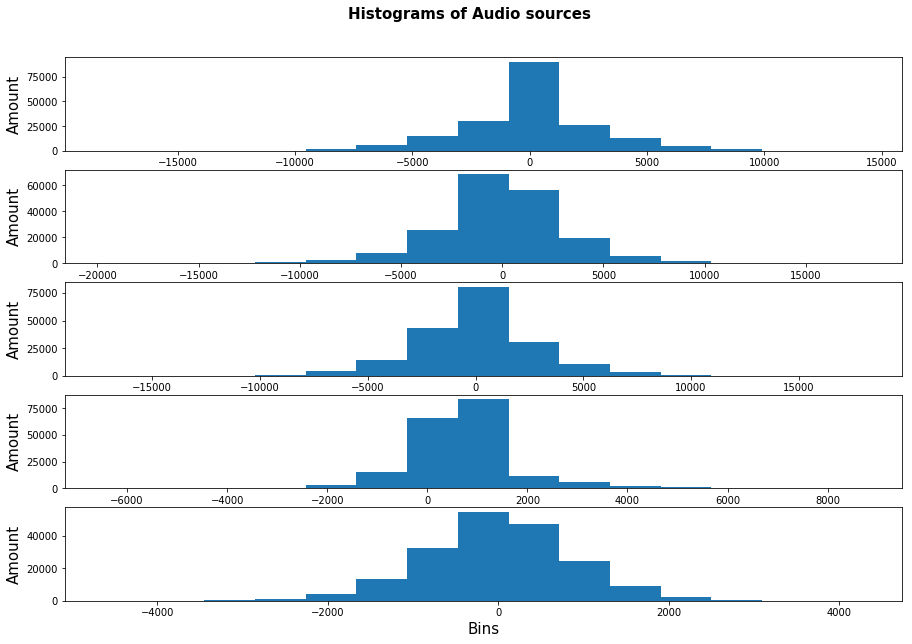

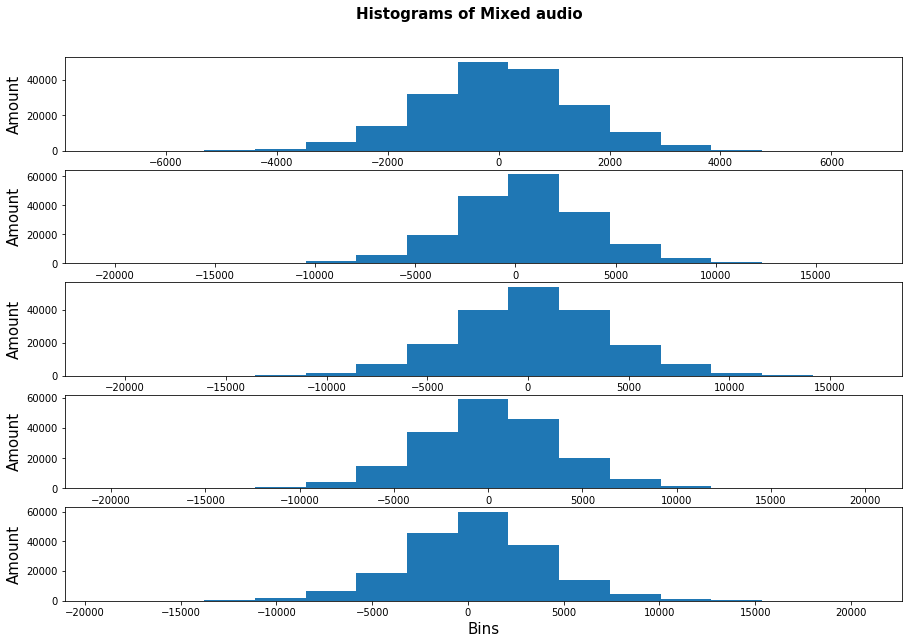

ICA converged at step  105
ICA converged at step  1296
ICA converged at step  792
ICA converged at step  159


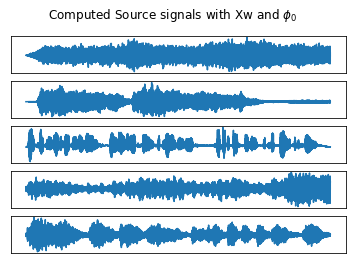

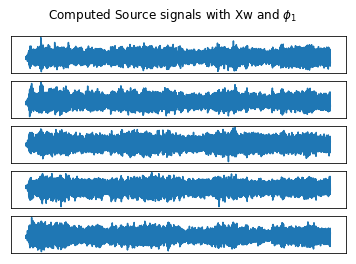

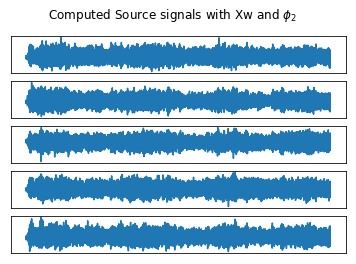

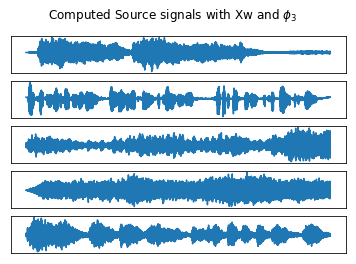

In [22]:
### 1.9 Audio demixing
A_audio = random_nonsingular_matrix(d=S_audio.shape[0])
X_audio = make_mixtures(S_audio, A_audio)
Xw_audio = whiten(X_audio)

plot_signals(X_audio,"Mixed audio")
plot_signals(Xw_audio,"Mixed xw audio")

plot_histograms(S_audio,"Histograms of Audio sources")    
plot_histograms(X_audio,"Histograms of Mixed audio")

labels_xw = ['Xw and $\phi_0$','Xw and $\phi_1$','Xw and $\phi_2$','Xw and $\phi_3$']

Wx_audio = [ICA(Xw_audio, activation_function=phi, learning_rate=0.501,max_steps=1e5) for phi in activation_functions]

#Wx_audio = [ICA(Xw_audio, activation_function=phi, learning_rate=0.501) for phi in [phi_0, phi_1, phi_3] ]
#Use this one for without phi_2 as difficult to converge
# Original X leads to NaNs

#plot_all_signals(X_audio,W_audio_X,labels)
recon_Xw_s_audio = plot_all_signals(Xw_audio,Wx_audio,labels_xw)


Report your results. Using which activation functions ICA recovers the sources?

$\phi_0$ and $\phi_3$ does a good job about recovering the original sources. While $\phi_1$ and $\phi_2$ are not doing so well, especially $\phi_2$, which might not converge within max steps if no decaying learning rate was used. 

### 1.10 Excess Kurtosis (15 points)
The (excess) kurtosis is a measure of 'peakedness' of a distribution. It is defined as
$$
\verb+Kurt+[X] = \frac{\mu_4}{\sigma^4} - 3 = \frac{\operatorname{E}[(X-{\mu})^4]}{(\operatorname{E}[(X-{\mu})^2])^2} - 3
$$
Here, $\mu_4$ is known as the fourth moment about the mean, and $\sigma$ is the standard deviation.
The '-3' term is introduced so that a Gaussian random variable has 0 excess kurtosis.
We will now try to understand the performance of the various activation functions by considering the kurtosis of the corresponding priors, and comparing those to the empirical kurtosis of our data.

#### 1.10.1 (10 points)
First, compute analytically the kurtosis of the four priors that you derived from the activation functions before. You may find it helpful to use an online service such as [Wolfram Alpha](https://www.wolframalpha.com/) or [Integral Calculator](https://www.integral-calculator.com/) to (help you) evaluate the required integrals. Give your answer as both an exact expression as well as a numerical approximation (for example $\frac{\pi}{2} \approx 1.571$).

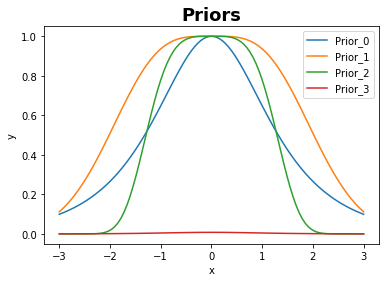

In [23]:
x = np.linspace(-3, 3, num=100)

prior_0 = p_0(x) 
prior_1 = p_1(x) 
prior_2 = p_2(x) 
prior_3 = p_3(x) 

fontsize = 18
#plt.subplot(1,2,1)
plt.plot(x, prior_0, label="Prior_0")
plt.plot(x, prior_1, label="Prior_1")
plt.plot(x, prior_2, label="Prior_2")
plt.plot(x, prior_3, label="Prior_3")

plt.xlabel("x")
plt.ylabel("y")
plt.title("Priors",fontsize=fontsize,fontweight="bold")
plt.legend()
plt.show()

From the plot it can be observed that each of the priors have a mean of 0. 
Thus we can consider:

$$
\verb+Kurt+[X] = \frac{\operatorname{E}[X^4]}{(\operatorname{E}[X^2])^2} - 3 = \frac{\int^\infty_\infty f(x) x^4 dx}{(\int^\infty_\infty f(x) x^2 dx)^2} - 3
$$

And also to make sure it is a probaility distribution that sums up to 1, a normalizing factor $\int^\infty_\infty f(x) dx$ has to be added:

$$
\verb+Kurt+[X] = \int^\infty_\infty f(x) dx \frac{\int^\infty_\infty f(x) x^4 dx}{(\int^\infty_\infty f(x) x^2 dx)^2} - 3
$$

Integrals are then computed with the given online integral calculator.
For the first prior, where $f(x) = \frac{1}{cosh(a)}$:

$$
\verb+Kurt+[X] =  \int^\infty_\infty \frac{1}{cosh(a)} dx \frac{\int^\infty_\infty  \frac{1}{cosh(a)} x^4 dx}{(\int^\infty_\infty  \frac{1}{cosh(a)} x^2 dx)^2} - 3 
$$

$$
=  \pi * \frac{ \frac{5\pi^5}{16} }{ (\frac{\pi^3}{4})^2} - 3 \approx 3.1416 * 1.5915 - 3 
$$

$$
=  2
$$

For the second prior, where $f(x) = e^{\frac{-a^2}{2}} * cosh(a)$:

$$
\verb+Kurt+[X] =  \int^\infty_\infty e^{\frac{-a^2}{2}} * cosh(a) dx \frac{\int^\infty_\infty  (e^{\frac{-a^2}{2}} * cosh(a)) * x^4 dx}{(\int^\infty_\infty  (e^{\frac{-a^2}{2}} * cosh(a)) * x^2 dx)^2} - 3 
$$

$$
=  \sqrt{2}\sqrt{\mathrm{e}}\sqrt{{\pi}} * \frac{ 5{\cdot}2^\frac{3}{2}\sqrt{\mathrm{e}}\sqrt{{\pi}} }{ (2^\frac{3}{2}\sqrt{\mathrm{e}}\sqrt{{\pi}})^2} - 3 \approx   4.132731 * \frac{41.3273135}{(8.26546)^2} - 3 
$$

$$
=  2.5 - 3 = - 0.5
$$

For the third prior, where $f(x) = e^{-\frac{a^4}{4}} $:

$$
\verb+Kurt+[X] =  \int^\infty_\infty e^{-\frac{a^4}{4}}  dx \frac{\int^\infty_\infty  e^{-\frac{a^4}{4}} * x^4 dx}{(\int^\infty_\infty  e^{-\frac{a^4}{4}}  * x^2 dx)^2} - 3 
$$

$$
=  \dfrac{\operatorname{\Gamma}\left(\frac{1}{4}\right)}{\sqrt{2}} 
* \frac{ \dfrac{\operatorname{\Gamma}\left(\frac{1}{4}\right)}{\sqrt{2}} }{ (\sqrt{2}\operatorname{\Gamma}\left(\dfrac{3}{4}\right))^2} - 3 \approx   2.56369 * \frac{2.563693}{(1.7330)^2} - 3 
$$

$$
=  2.563693352040848 * 0.85362768268 - 3 = 2.18843961523 - 3 = -0.81156038477 = -0.8116
$$

For the fourth prior, where $f(x) = \frac{1}{{(a^2 + 5})^{3}} $:

$$
\verb+Kurt+[X] =  \int^\infty_\infty \frac{1}{{(a^2 + 5})^{3}}  dx \frac{\int^\infty_\infty  \frac{1}{{(a^2 + 5})^{3}} * x^4 dx}{(\int^\infty_\infty  \frac{1}{{(a^2 + 5})^{3}}  * x^2 dx)^2} - 3 
$$

$$
=  \dfrac{3{\pi}}{8{\cdot}5^\frac{5}{2}}
* \frac{ \dfrac{3{\pi}}{8\sqrt{5}} }{ (\dfrac{{\pi}}{8{\cdot}5^\frac{3}{2}})^2} - 3 \approx  0.021074 * \frac{0.52686}{(0.035124)^2} - 3 
$$

$$
= 6
$$

In [24]:
### Include your answer here (you can use math.gamma if needed)
def get_kurtosis():
    # Return a list with 4 numbers / expressions
    # return [0, 0, 0, 0]
    
    return [2,-0.5, -0.81156038477, 6]

In [25]:
# Let's check
kurtosis = get_kurtosis()
print (kurtosis)
assert len(kurtosis) == 4


[2, -0.5, -0.81156038477, 6]


#### 1.10.2 (5 points)
Now use the `scipy.stats.kurtosis` function, with the `fisher` option set to `True`, to compute the empirical kurtosis of the dummy signals and the real audio signals.

Can you use this data to explain the performance of the various activation functions on the synthetic and real data?

In [26]:
### 1.10.2 Excess Kurtosis
from scipy.stats import kurtosis

dummy = kurtosis(S,fisher=True,axis=1)
real = kurtosis(S_audio,fisher=True,axis=1)

labels = ['Phi 0','Phi 1','Phi 2','Phi 3']

print("Kurtosis of dummy: ",dummy,"\n")
for i,recon_s in enumerate(recon_Xw_s):
    recon_s_values = kurtosis(recon_s,fisher=True,axis=1)
    #print(recon_s_values)
    diff = np.abs(np.sort(dummy) - np.sort(recon_s_values))
    print("Kurtosis diff of using " + labels[i] + " :",diff)
    print("Sum ", sum(diff),"\n") 
    
print("\n")
print("-" * 50)
print("Kurtosis of real: ",real,"\n")

for i,recon_s in enumerate(recon_Xw_s_audio):
    recon_s_values = kurtosis(recon_s,fisher=True,axis=1) 
    #print(recon_s_values)
    diff = np.abs(np.sort(real) - np.sort(recon_s_values))
    print("Kurtosis diff of using " + labels[i] + " :",diff)
    print("Sum ", sum(diff),"\n") 
    
print("-" * 50)

Kurtosis of dummy:  [-1.19640244 -1.48287113 -1.84019701 -1.2000384  -0.28623937] 

Kurtosis diff of using Phi 0 : [1.20862068 1.48004341 1.30178216 1.33964948 0.66961562]
Sum  5.999711349318974 

Kurtosis diff of using Phi 1 : [0.01267196 0.00071856 0.03661121 0.09724132 0.00721685]
Sum  0.1544598961376804 

Kurtosis diff of using Phi 2 : [0.01181035 0.0058097  0.0210056  0.03442128 0.00706639]
Sum  0.08011331344369088 

Kurtosis diff of using Phi 3 : [1.28854156 1.47747328 1.25136693 1.37909257 0.62723811]
Sum  6.023712457212979 



--------------------------------------------------
Kurtosis of real:  [1.79431517 2.06885064 1.93609295 5.05191721 0.53887581] 

Kurtosis diff of using Phi 0 : [0.00013205 0.00086188 0.00117785 0.00500378 0.00138259]
Sum  0.00855815569638052 

Kurtosis diff of using Phi 1 : [0.27956037 1.51478335 1.62465824 1.6603229  4.51589351]
Sum  9.595218363425975 

Kurtosis diff of using Phi 2 : [0.29210104 1.53642173 1.65487224 1.68069074 4.61512714]
Sum  9.7792128

The (excess) kurtosis is a measure of 'peakedness' of a distribution as described above and it is desired that our priors of S ($\phi$) is a good activation function ifthe original source signals are reconstructred. Thus the kurtosis values should be similar as well if they have a similar shape. This means that we can take the difference and see which activation function leads to a minimal difference. The activation function with a minimal sum of difference is a good activation function.
For the dummy signals, the sum of difference is minimal for phi 1 and phi 2, which is supported by the plots of dummy signals compared to the reconstructed signals in question 1.8.
For the audio signals, phi 0 and phi 3 are the winners and is also supported at the cell of audio demixing in question 1.9. 